In [1]:
import pandas as pd
import category_encoders as ce
import seaborn as sn
import eli5
import matplotlib.pyplot as plt
from eli5.sklearn import PermutationImportance
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from IPython.display import display

In [15]:
data = pd.read_excel('Copia de Base de datos prueba tecnica.xlsx',sheet_name='DB')
#Iprimimos la la longitud de los datos originales
print("El número de registros originalmente es " + str(len(data)))
#Quitamos los duplicados de los datos
data = data.drop_duplicates()
print("El número de registros sin duplicados  es " + str(len(data)))
df = data.groupby('cliente_id').first()
print("El número de registros únicos sin ambiguedades  es " + str(len(df)))
print(df.head())


El número de registros originalmente es 19942
El número de registros sin duplicados  es 12549
El número de registros únicos sin ambiguedades  es 12106
                REGIONAL  DEPARTAMENTO TECNOL           GERENCIA  \
cliente_id                                                         
39787             CENTRO  CUNDINAMARCA    HFC                FVD   
107545      EJE CAFETERO     RISARALDA   GPON  AUR&CONSTRUCTORES   
135765      NOROCCIDENTE     ANTIOQUIA    HFC             RETAIL   
159481      NOROCCIDENTE     ANTIOQUIA    HFC            CONTACT   
247126           ORIENTE     SANTANDER    HFC            TIENDAS   

           CANAL_HOMOLOGADO_MILLICON tipo_fuerza_venta estrato  \
cliente_id                                                       
39787                            FVD         INDIRECTA       3   
107545                URBANIZACIONES         INDIRECTA      SE   
135765                        RETAIL         INDIRECTA       6   
159481                           SAC      

In [16]:
df = df.fillna(0)
num_cols = list(df._get_numeric_data().columns)
cat_cols = list(set(df.columns) - set(num_cols))
print(len(num_cols))
print(len(cat_cols))

11
10


In [17]:
y = df['Incumplimiento_pago']
X = df.drop(['Incumplimiento_pago'], axis= 1)


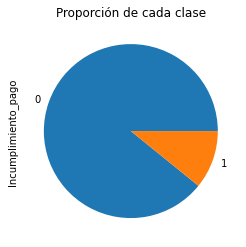

<ipython-input-18-22663fb768b3>:11: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  ax1.pie(cantidad, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)


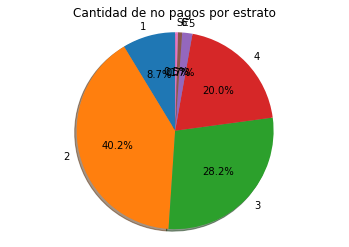

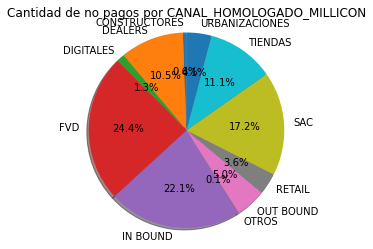

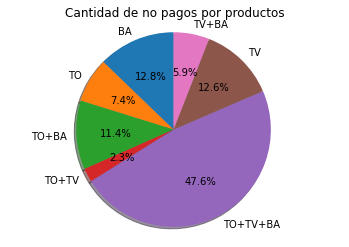

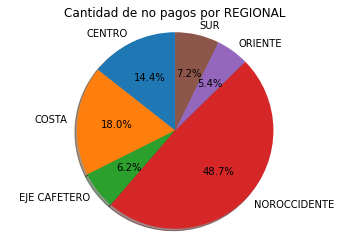

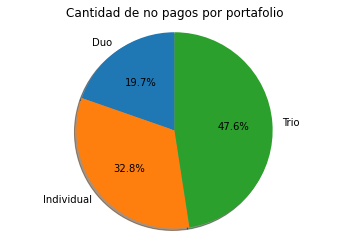

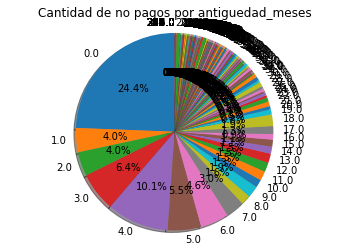

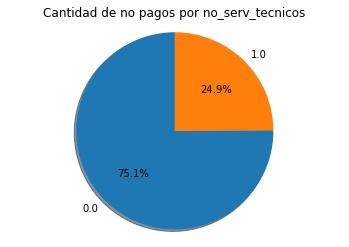

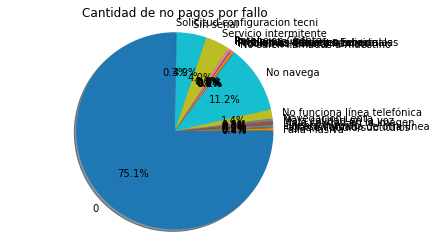

In [18]:
df.Incumplimiento_pago.value_counts().plot.pie(y='label', title='Proporción de cada clase')
plt.show()

features = ['estrato','CANAL_HOMOLOGADO_MILLICON','productos','REGIONAL','portafolio','antiguedad_meses','no_serv_tecnicos','fallo']

for f in features:
	datos = df[[f, 'Incumplimiento_pago']].groupby([f]).sum()
	labels = datos.index.values.tolist()
	cantidad = list(datos.values.tolist())
	fig1, ax1 = plt.subplots()
	ax1.pie(cantidad, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
	ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
	plt.title('Cantidad de no pagos por ' + f)
	plt.show()


In [19]:
encoder = ce.TargetEncoder(cols=cat_cols)
X = encoder.fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
lr = LogisticRegression()

steps = [('over', SMOTE()), ('model', lr)]
pipeline = Pipeline(steps=steps)
pipeline.fit(X_train, y_train)
y_hat = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X)
y_prob = pd.DataFrame(y_prob)
y_prob.to_csv('prob1.csv')
coef = lr.coef_
coef = pd.DataFrame(coef)
coef.columns = X.columns
coef = coef.transpose()
coef = coef.abs()
coef = coef.sort_values(by=[0], ascending= False)
print(coef)
print(classification_report(y_test, y_hat))


                                   0
estrato                    14.634195
CANAL_HOMOLOGADO_MILLICON   5.089038
productos                   3.570661
REGIONAL                    3.188812
DEPARTAMENTO                3.098246
portafolio                  3.003723
quejas_fraude               2.548387
asesoria_servicios          1.815522
GERENCIA                    1.680695
asesoria_factura            1.208499
TECNOL                      1.038490
retencion                   0.921170
reagendamiento              0.784819
tipo_fuerza_venta           0.664346
traslado                    0.661750
no_serv_tecnicos            0.491347
Otras                       0.299133
fallo                       0.199961
pedidos_peticiones          0.064842
antiguedad_meses            0.007811
              precision    recall  f1-score   support

           0       0.95      0.75      0.84      2160
           1       0.24      0.65      0.35       262

    accuracy                           0.74      2422
   ma

c:\users\leo1p\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
import numpy as np
proba=pd.DataFrame()
proba['Cliente'] = X.index
proba['Probabilidad'] = y_prob[1]
proba = proba.sort_values(by=['Probabilidad'], ascending = False)
proba['Riesgo'] = np.zeros(X.index.shape)
for i in range(1,len(proba)):
    if proba['Probabilidad'][i] > 0.8:
        proba['Riesgo'][i]=1
    elif 0.5 < proba['Probabilidad'][i] <= 0.8:
        proba['Riesgo'][i]=2
    else:
        proba['Riesgo'][i]=3
proba.to_csv('probLogisticRegression.csv')

<ipython-input-32-d854e0a6aa7c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proba['Riesgo'][i]=3
<ipython-input-32-d854e0a6aa7c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proba['Riesgo'][i]=1
<ipython-input-32-d854e0a6aa7c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proba['Riesgo'][i]=2


<BarContainer object of 12106 artists>

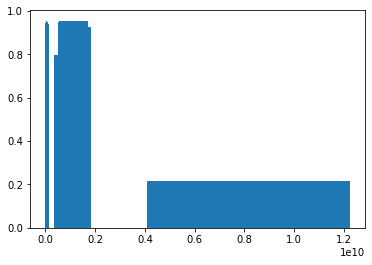

In [10]:
plt.bar(proba['Cliente'], proba['Probabilidad'], width= proba['Cliente'])


              precision    recall  f1-score   support

           0       0.95      0.80      0.86      2160
           1       0.27      0.62      0.38       262

    accuracy                           0.78      2422
   macro avg       0.61      0.71      0.62      2422
weighted avg       0.87      0.78      0.81      2422

[[1722  438]
 [ 100  162]]


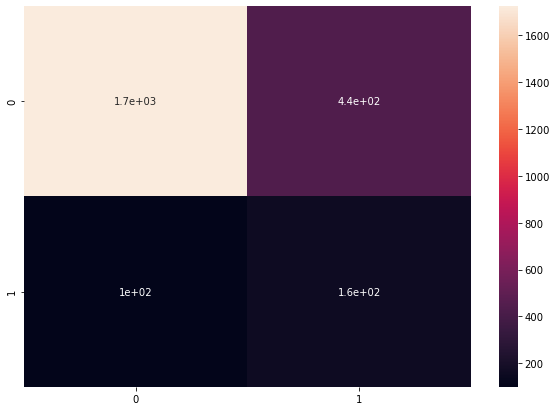

Weight,Feature
0.1134 ± 0.0041,estrato
0.0982 ± 0.0077,antiguedad_meses
0.0676 ± 0.0042,portafolio
0.0666 ± 0.0034,productos
0.0393 ± 0.0031,CANAL_HOMOLOGADO_MILLICON
0.0338 ± 0.0026,no_serv_tecnicos
0.0280 ± 0.0020,DEPARTAMENTO
0.0259 ± 0.0036,REGIONAL
0.0199 ± 0.0018,fallo
0.0176 ± 0.0011,GERENCIA


In [33]:
def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(20, input_dim=20, activation='relu'))
	model.add(Dense(20, activation ='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

estimator = KerasClassifier(build_fn=create_baseline, epochs=200, batch_size=5, verbose=0)
steps = [('over', SMOTE()), ('model', estimator)]
pipeline = Pipeline(steps=steps)
pipeline.fit(X_train, y_train)
y_hat = pipeline.predict(X_test)
print(classification_report(y_test, y_hat))
con = confusion_matrix(y_test, y_hat)
print(con)
df_cm = pd.DataFrame(con, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()
perm = PermutationImportance(estimator, random_state=1).fit(X_train,y_train)
display(eli5.show_weights(perm, feature_names = X_train.columns.tolist()))

In [34]:
y_prob=pipeline.predict_proba(X)
proba=pd.DataFrame()
proba['Cliente'] = X.index
proba['Probabilidad'] = y_prob[:,1]
proba['ValorReal'] = y  
proba = proba.sort_values(by=['Probabilidad'], ascending = False)
proba['Riesgo'] = np.zeros(X.index.shape)
for i in range(1,len(proba)):
    if proba['Probabilidad'][i] > 0.8:
        proba['Riesgo'][i]=1
    elif 0.5 < proba['Probabilidad'][i] <= 0.8:
        proba['Riesgo'][i]=2
    else:
        proba['Riesgo'][i]=3
proba.to_csv('probNN.csv')

<ipython-input-34-ea6fd7a54c6b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proba['Riesgo'][i]=3
<ipython-input-34-ea6fd7a54c6b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proba['Riesgo'][i]=2
<ipython-input-34-ea6fd7a54c6b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proba['Riesgo'][i]=1


<BarContainer object of 12106 artists>

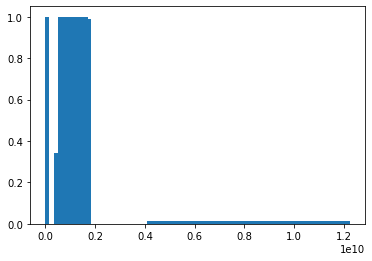

In [35]:
plt.bar(proba['Cliente'], proba['Probabilidad'], width= proba['Cliente'])
